In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import kaggle
import wandb
import random

OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/CS 663 Project

Mounted at /content/drive
/content/drive/MyDrive/CS 663 Project


In [ ]:
!kaggle kernels output shahupatiliitb/lung-segmentation-from-chest-x-ray-dataset -p /weights --unzip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
! wandb login
# b83c64c18cdd08a2936eedd4c05e5d8c44197f77

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shahuwncc (ishan-iitb) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# import kagglehub
# path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

  Subset      Class  Count
0  train  PNEUMONIA   3875
1  train     NORMAL   1341
2   test  PNEUMONIA    390
3   test     NORMAL    234
4    val  PNEUMONIA      8
5    val     NORMAL      8


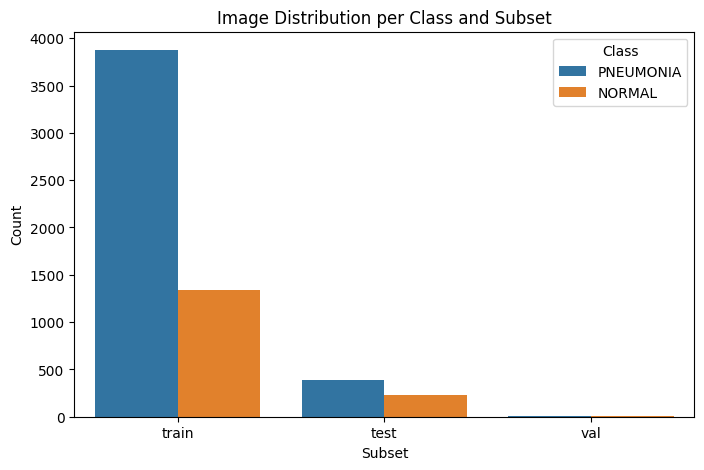

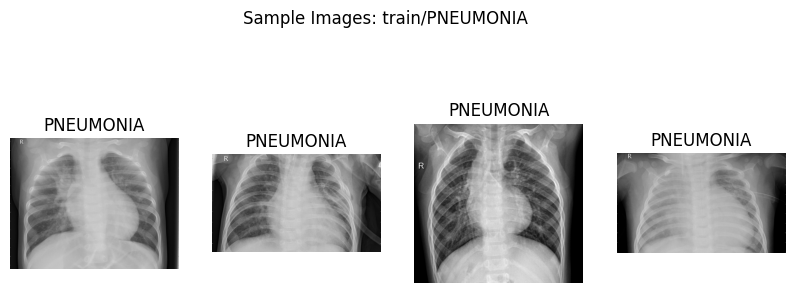

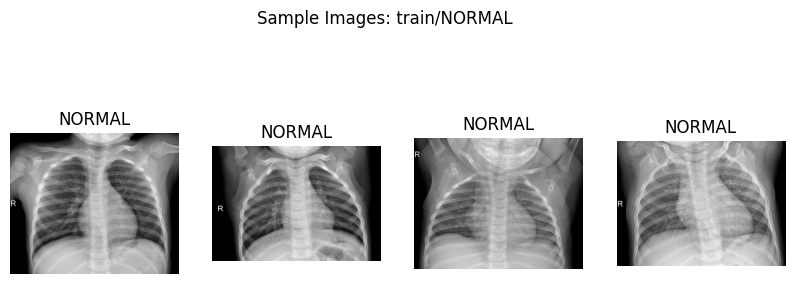


Image dimension summary:
             Width       Height
count   416.000000   416.000000
mean   1478.574519  1109.805288
std     453.895279   468.899936
min     654.000000   356.000000
25%    1118.000000   720.000000
50%    1394.000000  1021.000000
75%    1788.500000  1395.000000
max    2844.000000  2713.000000


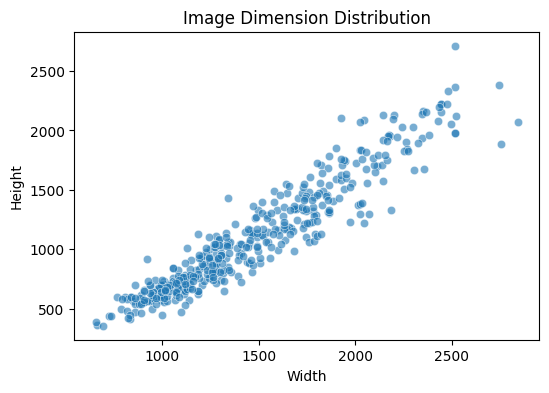

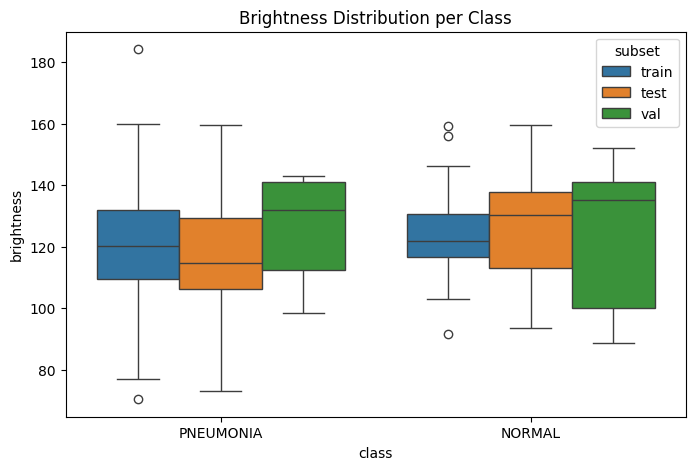

Normal:Pneumonia ratio = 0.37:1


In [ ]:

data_dir = 'data'

subsets = ['train', 'test', 'val']
classes = ['PNEUMONIA', 'NORMAL']

data_summary = []

for subset in subsets:
    for cls in classes:
        folder = os.path.join(data_dir, subset, cls)
        count = len(os.listdir(folder))
        data_summary.append([subset, cls, count])

df_summary = pd.DataFrame(data_summary, columns=['Subset', 'Class', 'Count'])
print(df_summary)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_summary, x='Subset', y='Count', hue='Class')
plt.title('Image Distribution per Class and Subset')
plt.show()

def show_samples(subset, cls, n=4):
    folder = os.path.join(data_dir, subset, cls)
    images = os.listdir(folder)[:n]

    plt.figure(figsize=(10, 4))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{cls}")
        plt.axis('off')
    plt.suptitle(f"Sample Images: {subset}/{cls}")
    plt.show()

show_samples('train', 'PNEUMONIA')
show_samples('train', 'NORMAL')

image_shapes = []
for subset in subsets:
    for cls in classes:
        folder = os.path.join(data_dir, subset, cls)
        for img_name in os.listdir(folder)[:100]:  # sample first 100 images for speed
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path)
            image_shapes.append(img.size)

shapes_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
print("\nImage dimension summary:")
print(shapes_df.describe())

plt.figure(figsize=(6,4))
sns.scatterplot(data=shapes_df, x='Width', y='Height', alpha=0.6)
plt.title('Image Dimension Distribution')
plt.show()

def avg_brightness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img)

brightness = {'subset': [], 'class': [], 'brightness': []}
for subset in subsets:
    for cls in classes:
        folder = os.path.join(data_dir, subset, cls)
        for img_name in os.listdir(folder)[:100]:
            img_path = os.path.join(folder, img_name)
            brightness['subset'].append(subset)
            brightness['class'].append(cls)
            brightness['brightness'].append(avg_brightness(img_path))

brightness_df = pd.DataFrame(brightness)

plt.figure(figsize=(8,5))
sns.boxplot(data=brightness_df, x='class', y='brightness', hue='subset')
plt.title('Brightness Distribution per Class')
plt.show()

ratio = df_summary[df_summary['Class'] == 'NORMAL']['Count'].sum() / \
         df_summary[df_summary['Class'] == 'PNEUMONIA']['Count'].sum()
print(f"Normal:Pneumonia ratio = {ratio:.2f}:1")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

train_data = datasets.ImageFolder(os.path.join("data", 'train'), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join("data", 'test'), transform=test_transforms)
classes = train_data.classes

class_counts = np.bincount([label for _, label in train_data.samples])
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_data.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


model = models.efficientnet_b0(weights='IMAGENET1K_V1')
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, 1)
)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights[0]/class_weights[1]]).to(device))
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr= lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 195MB/s]


In [ ]:
import torch
from tqdm import tqdm
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=10, run=None):
    model.train()
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_loader)
        train_acc = correct / total
        scheduler.step(avg_loss)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={train_acc:.4f}")

        if run:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_loss,
                "train_accuracy": train_acc
            })

    print("Training complete.")
    torch.save(model.state_dict(), "best_pneumonia_model.pth")
    print("Model saved as best_pneumonia_model.pth")
    # if run:
    #     run.finish()
    return model


def evaluate(model, test_loader, classes, run=None):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy()
            preds = (outputs > 0.5).astype(int)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.flatten())

    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    if run:
        wandb.log({"classification_report": report})

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    if run:
        wandb.log({"confusion_matrix": wandb.Image(plt)})

    plt.show()


In [ ]:
import wandb, os, torch


run = wandb.init(
    entity="ishan-iitb",
    project="CS 663",
    config={"learning_rate": lr, "architecture": "efficientnet_b0", "epochs": 10, "data": "raw data"},
)


model = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=10, run=run)
model.load_state_dict(torch.load("best_pneumonia_model.pth"))
evaluate(model, test_loader, classes=['Normal', 'Pneumonia'], run=run)


os.makedirs("weights", exist_ok=True)
torch.save(model.state_dict(), "weights/efficientnet_b0.pth")
wandb.save("weights/efficientnet_b0.pth")
run.finish()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: shahuwncc (ishan-iitb) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1/10]: 100%|██████████| 326/326 [03:00<00:00,  1.81it/s, loss=0.34]


Epoch 1: Loss=0.5139, Accuracy=0.8637


Epoch [2/10]: 100%|██████████| 326/326 [02:36<00:00,  2.08it/s, loss=0.14]


Epoch 2: Loss=0.3125, Accuracy=0.9187


Epoch [3/10]: 100%|██████████| 326/326 [02:30<00:00,  2.17it/s, loss=0.0573]


Epoch 3: Loss=0.2832, Accuracy=0.9279


Epoch [4/10]: 100%|██████████| 326/326 [02:31<00:00,  2.16it/s, loss=0.449]


Epoch 4: Loss=0.2488, Accuracy=0.9388


Epoch [5/10]: 100%|██████████| 326/326 [02:32<00:00,  2.14it/s, loss=1.12]


Epoch 5: Loss=0.2468, Accuracy=0.9433


Epoch [6/10]: 100%|██████████| 326/326 [02:31<00:00,  2.15it/s, loss=0.175]


Epoch 6: Loss=0.2429, Accuracy=0.9425


Epoch [7/10]: 100%|██████████| 326/326 [02:31<00:00,  2.15it/s, loss=0.802]


Epoch 7: Loss=0.2185, Accuracy=0.9486


Epoch [8/10]: 100%|██████████| 326/326 [02:31<00:00,  2.16it/s, loss=0.131]


Epoch 8: Loss=0.2123, Accuracy=0.9503


Epoch [9/10]: 100%|██████████| 326/326 [02:31<00:00,  2.16it/s, loss=0.646]


Epoch 9: Loss=0.1924, Accuracy=0.9563


Epoch [10/10]: 100%|██████████| 326/326 [02:31<00:00,  2.15it/s, loss=0.117]

Epoch 10: Loss=0.1773, Accuracy=0.9588
Training complete.
Model saved as best_pneumonia_model.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇▇██
train_loss,█▄▃▂▂▂▂▂▁▁
epoch,10
train_accuracy,0.95878
train_loss,0.17726



Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.88      0.92       234
   Pneumonia       0.93      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.93      0.94       624
weighted avg       0.95      0.95      0.94       624



Error: You must call wandb.init() before wandb.log()


Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.88      0.92       234
   Pneumonia       0.93      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.93      0.94       624
weighted avg       0.95      0.95      0.94       624



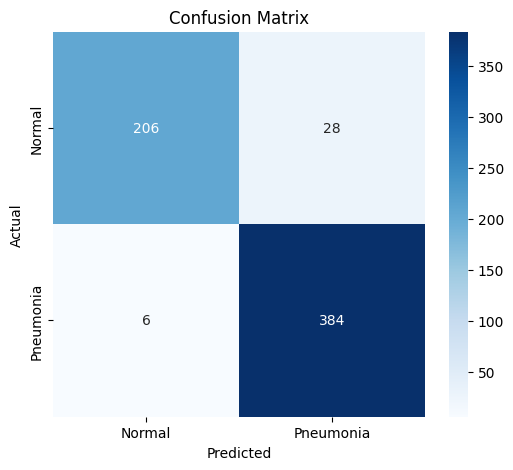

OSError: [Errno 95] Operation not supported: '/content/drive/MyDrive/CS 663 Project/weights/efficientnet_b0.pth' -> '/content/drive/MyDrive/CS 663 Project/wandb/run-20251026_094239-2z1r1nkc/files/weights/efficientnet_b0.pth'

In [ ]:
run = wandb.init(
    entity="ishan-iitb",
    project="CS 663",
    config={"learning_rate": lr, "architecture": "efficientnet_b0", "epochs": 10, "data": "raw data"},
)

evaluate(model, test_loader, classes=['Normal', 'Pneumonia'], run=run)

os.makedirs("weights", exist_ok=True)
torch.save(model.state_dict(), "weights/efficientnet_b0.pth")
wandb.save("weights/efficientnet_b0.pth")
run.finish()
